In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os

def load_image_float(path):
    """Read PNG -> float32 in [0,1]."""
    img = imread(path).astype(np.float32)
    if img.max() > 1.0:  # some readers return 0..255
        img = img / 255.0
    return img

def save_image(path, img_float01):
    """Save float [0,1] image using matplotlib (keeps colors)."""
    plt.imsave(path, np.clip(img_float01, 0, 1))


In [ ]:

class GMM:
    def __init__(self, k=3, max_iters=200, tol=1e-4, reg_covar=1e-6, verbose=False):
        self.k = int(k)
        self.max_iters = int(max_iters)
        self.tol = float(tol)
        self.reg_covar = float(reg_covar)
        self.verbose = verbose

        self.pi_ = None          # (k,)
        self.mu_ = None          # (k,d)
        self.Sigma_ = None       # (k,d,d)
        self.lkh_history_ = []   # list of log-likelihoods

    # ---------- vectorized helpers ----------
    def _log_gaussians(self, X):
        """
        Return log N(x_i | mu_k, Sigma_k) for all i,k as (n,k).
        Uses batched slogdet and batched inverse + einsum for Mahalanobis.
        """
        X = np.asarray(X, float)             # (n,d)
        n, d = X.shape
        k = self.k

        # Regularize covariances
        regI = self.reg_covar * np.eye(d)
        Sigma = self.Sigma_ + regI[None, :, :]     # (k,d,d)

        # log |Sigma_k|
        sign, logdet = np.linalg.slogdet(Sigma)    # (k,)
        # Sigma_k^{-1}

        Sigma_inv = np.linalg.inv(Sigma)           # (k,d,d)
        # diffs: (n,k,d)
        diff = X[:, None, :] - self.mu_[None, :, :]

        # Mahalanobis: (x-mu)^T Sigma^{-1} (x-mu)  -> (n,k)
        quad = np.einsum('nkd,kde,nke->nk', diff, Sigma_inv, diff)

        log_norm = -0.5 * (d * np.log(2*np.pi) + logdet[None, :] + quad)
        return log_norm  # (n,k)

    def _logsumexp(self, A, axis=1):
        m = np.max(A, axis=axis, keepdims=True)
        return (m + np.log(np.sum(np.exp(A - m), axis=axis, keepdims=True))).squeeze(axis)

    def _e_step(self, X):
        """
        Compute responsibilities gamma (n,k) and total log-likelihood (scalar).
        """
        log_pdf = self._log_gaussians(X)                 # (n,k)
        log_mix = np.log(self.pi_)[None, :]              # (1,k)
        log_joint = log_pdf + log_mix                    # (n,k)

        log_sum = self._logsumexp(log_joint, axis=1)     # (n,)
        ll = float(np.sum(log_sum))                      # total log-likelihood

        # gamma = exp(log_joint - log_sum[:,None])
        gamma = np.exp(log_joint - log_sum[:, None])     # (n,k)
        return gamma, ll

    def _m_step(self, X, gamma):
        """
        Update pi_, mu_, Sigma_ from responsibilities. Vectorized.
        """
        n, d = X.shape
        Nk = gamma.sum(axis=0)                           # (k,)
        Nk_safe = np.clip(Nk, 1e-12, None)

        # means (k,d): (gamma^T X) / Nk
        self.mu_ = (gamma.T @ X) / Nk_safe[:, None]

        # covariances: sum_i gamma_{ik} (x_i - mu_k)(x_i - mu_k)^T / Nk
        diff = X[:, None, :] - self.mu_[None, :, :]      # (n,k,d)
        # (k,d,d) via einsum over n with weights gamma
        self.Sigma_ = np.einsum('nk,nkd,nke->kde', gamma, diff, diff) / Nk_safe[:, None, None]
        # regularize a bit (kept small; main regularization added in _log_gaussians)
        self.Sigma_ += self.reg_covar * np.eye(d)[None, :, :]

        # mixture weights
        self.pi_ = Nk_safe / n

    def _init_params(self, X):
        """
        Simple init: pick k random rows as means; uniform pi; diagonal cov from data.
        """
        n, d = X.shape
        idx = np.random.choice(n, self.k, replace=False)
        self.mu_ = X[idx].astype(float)                  
        var = np.var(X, axis=0) + self.reg_covar
        self.Sigma_ = np.tile(np.diag(var)[None, :, :], (self.k, 1, 1))  # (k,d,d)
        self.pi_ = np.ones(self.k, dtype=float) / self.k
        self.lkh_history_ = []

    # ---------- public API ----------
    def fit(self, X):
        """
        EM for GMM.
        Stores log-likelihood per iteration in lkh_history_.
        """
        X = np.asarray(X, float)
        if X.ndim != 2:
            print("fit: X must be 2D.")
            return self

        self._init_params(X)
        prev_ll = -np.inf

        for it in range(self.max_iters):  # iteration loop only
            gamma, ll = self._e_step(X)
            self._m_step(X, gamma)
            self.lkh_history_.append(ll)

            if self.verbose:
                print(f"iter {it:3d} | loglik {ll:.6f}")

            if np.isfinite(prev_ll) and (ll - prev_ll) < self.tol:
                break
            prev_ll = ll
        return self

    def getMembership(self, X):
        """Return responsibilities gamma_{ic} (n,k)."""
        X = np.asarray(X, float)
        gamma, _ = self._e_step(X)
        return gamma

    def getLikelihood(self, X):
        """Return total log-likelihood of X under current parameters."""
        X = np.asarray(X, float)
        _, ll = self._e_step(X)
        return ll

    def drawLikelihood(self):
        """Plot log-likelihood vs iteration from the last fit."""
        if not self.lkh_history_:
            print("drawLikelihood: fit the model first.")
            return
        plt.figure(figsize=(6,4))
        plt.plot(np.arange(1, len(self.lkh_history_)+1), self.lkh_history_, marker='o')
        plt.xlabel("Iteration")
        plt.ylabel("Log-Likelihood")
        plt.title(f"GMM (k={self.k}) — Log-Likelihood vs Iterations")
        plt.grid(True, linestyle="--", alpha=0.4)
        plt.show()


In [29]:
def assign_semantics_from_means(mu_k):
    """
    mu_k is the array of shape (3,3) representing the means of the 3 Gaussian components (mean) in RGB space.
    Robustly map 3 components to {land, water, vegetation} using unique picks.
    Strategy:
      1) pick WATER = argmax Blue
      2) from remaining, pick VEGETATION = argmax Green
      3) LAND = the leftover
    """
    mu_k = np.asarray(mu_k, float)  # (3,3) in RGB [0,1]
    assert mu_k.shape == (3, 3), "Expect k=3 and RGB channels."

    remaining = {0, 1, 2}

    # 1) water by Blue
    comp_water = int(np.argmax(mu_k[:, 2]))
    remaining.remove(comp_water)

    # 2) vegetation by Green among remaining
    rem = sorted(list(remaining))
    # pick the index in 'rem' that maximizes green
    pick = int(np.argmax(mu_k[rem, 1]))
    comp_veg = rem[pick]
    remaining.remove(comp_veg)

    # 3) land is the last one
    comp_land = remaining.pop()

    comp2sem = {
        comp_land: "land",
        comp_water: "water",
        comp_veg: "vegetation",
    }
    sem2color = {
        "land": (0.80, 0.60, 0.40),      # tan
        "water": (0.00, 0.00, 1.00),     # blue
        "vegetation": (0.00, 0.80, 0.00) # green
    }
    return comp2sem, sem2color


In [ ]:
def segment_image_with_gmm(image_path, k=3, reg_covar=1e-6, max_iters=200, tol=1e-4, show=True):
    """
    Loads an image, fits GMM(k=3) on RGB, assigns semantic classes, and returns segmented image.
    """
    assert k == 3, "Per instructions: use k=3 (Land, Water, Vegetation)."

    # 1) Load image and flatten to Nx3 features
    img = load_image_float(image_path)
    h, w, c = img.shape
    assert c == 3, "Expecting an RGB image."
    X = img.reshape(-1, 3)

    # 2) GMM
    gmm = GMM(k=k, max_iters=max_iters, tol=tol, reg_covar=reg_covar, verbose=False).fit(X)

    # 3) Posterior membership and hard labels
    Gamma = gmm.getMembership(X)           # (N,k)
    labels = np.argmax(Gamma, axis=1)      # (N,)

    comp2sem, sem2color = assign_semantics_from_means(gmm.mu_)
    # build a per-component color table
    comp_colors = np.zeros((k, 3), dtype=np.float32)
    for comp in range(k):
        sem = comp2sem[comp]
        comp_colors[comp] = np.array(sem2color[sem], dtype=np.float32)

    # 5) Color each pixel by its component's semantic color
    seg_flat = comp_colors[labels]                 # (N,3)
    seg_img = seg_flat.reshape(h, w, 3)

    # 6) Show results + likelihood curve
    if show:
        fig, axs = plt.subplots(1, 3, figsize=(12,4))
        axs[0].imshow(img); axs[0].set_title("Original"); axs[0].axis("off")
        axs[1].imshow(seg_img); axs[1].set_title("Segmented (k=3)"); axs[1].axis("off")
        axs[2].plot(np.arange(1, len(gmm.lkh_history_)+1), gmm.lkh_history_, marker='o')
        axs[2].set_xlabel("Iteration"); axs[2].set_ylabel("Log-Likelihood")
        axs[2].set_title("EM Convergence")
        axs[2].grid(True, linestyle="--", alpha=0.4)
        plt.tight_layout()
        plt.show()

        # Print counts by semantic class
        unique, counts = np.unique(labels, return_counts=True)
        print("Pixel counts by semantic class:")
        for comp, ct in zip(unique, counts):
            print(f"  {comp2sem[comp]:>11s}: {ct}")

    # 7) Save segmented image next to original
    base, ext = os.path.splitext(image_path)
    out_path = f"{base}_segmented_k3.png"
    save_image(out_path, seg_img)
    print("Saved:", out_path)

    return seg_img, gmm


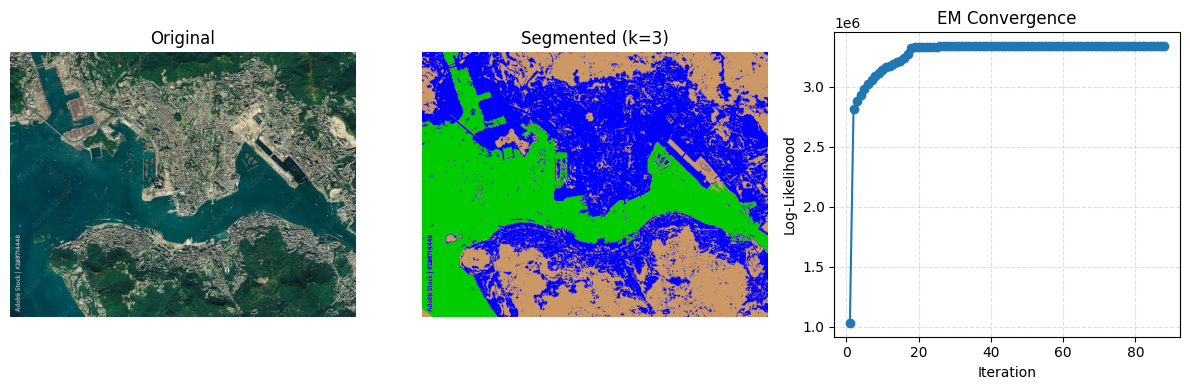

Pixel counts by semantic class:
        water: 315030
         land: 240472
   vegetation: 211498
Saved: satellite_1_segmented_k3.png


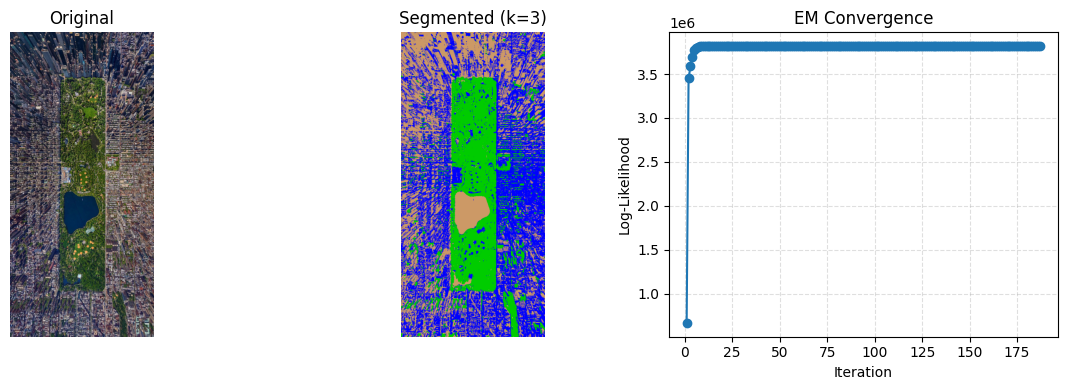

Pixel counts by semantic class:
        water: 516194
         land: 397827
   vegetation: 293979
Saved: satellite_2_segmented_k3.png


In [31]:
seg1, gmm1 = segment_image_with_gmm("satellite_1.png", k=3)
seg2, gmm2 = segment_image_with_gmm("satellite_2.png", k=3)


Preprocessing: RGB in [0,1], flattened to (N,3).

Model: GMM with k=3, EM convergence (include the likelihood plot).

Mapping: cluster means → water/vegetation/land; fixed, distinct colors.

Result: show both images (original + segmented) and confirm segments are clearly visible.

In [ ]:
import numpy as np, cv2

def make_segmentation_video_cv2(image_path, output_path, k=3, max_iters=30, fps=2):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        print(f" could not read image: {image_path}")
        return
    H, W = img.shape[:2]
    X = img.reshape(-1, 3).astype(np.float32) / 255.0

    gmm = GMM(k=k, max_iters=max_iters, tol=1e-4, reg_covar=1e-6, verbose=False)
    gmm._init_params(X)
    lls = []

    vw = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (3*W, H))
    if not vw.isOpened():
        vw = cv2.VideoWriter(output_path.rsplit('.',1)[0]+'.avi', cv2.VideoWriter_fourcc(*'XVID'), fps, (3*W, H))
        if not vw.isOpened():
            print(" VideoWriter failed ."); return

    def ll_panel(vals):
        pane = np.full((H, W, 3), 255, np.uint8)
        if len(vals) < 2:
            cv2.putText(pane, "Log-Likelihood", (10, 24), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 2, cv2.LINE_AA)
            return pane
        xs = np.linspace(0, W-1, len(vals)).astype(int)
        vmin, vmax = float(min(vals)), float(max(vals))
        ys = np.full_like(xs, H//2) if vmax==vmin else ((1 - (np.array(vals)-vmin)/(vmax-vmin))*(H-1)).astype(int)
        pts = np.vstack([xs, ys]).T.reshape(-1,1,2)
        cv2.polylines(pane, [pts], False, (0,0,0), 2, cv2.LINE_AA)
        cv2.putText(pane, "Log-Likelihood", (10, 24), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 2, cv2.LINE_AA)
        return pane

    for it in range(1, max_iters+1):
        gamma, ll = gmm._e_step(X)
        gmm._m_step(X, gamma)
        lls.append(ll)

        labels = np.argmax(gamma, axis=1)
        seg = (gmm.mu_[labels].reshape(H, W, 3) * 255.0).clip(0,255).astype(np.uint8)

        seg_ann = seg.copy()
        cv2.putText(seg_ann, f"Iteration {it}", (12, 28), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,0), 3, cv2.LINE_AA)
        cv2.putText(seg_ann, f"Iteration {it}", (12, 28), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 1, cv2.LINE_AA)

        right = ll_panel(lls)
        frame = cv2.hconcat([img, seg_ann, right])
        vw.write(np.ascontiguousarray(frame))

    vw.release()
    print(f"video saved: {output_path}")


In [46]:
make_segmentation_video_cv2("satellite_1.png", "satellite1_segmentation.mp4", k=3, max_iters=200, fps=2)


[ok] video saved: satellite1_segmentation.mp4


In [47]:
make_segmentation_video_cv2("satellite_2.png", "satellite2_segmentation.mp4", k=3, max_iters=200, fps=2)


[ok] video saved: satellite2_segmentation.mp4


https://iiithydstudents-my.sharepoint.com/:f:/g/personal/akshith_reddy_students_iiit_ac_in/ErVJWdzl7o9MtV95dc2I4BcBDffUxcaIlVNitda59JoppA?e=uFzhZv